# Detección del medidor

### Importar librerías principales

In [586]:
import numpy as np
import argparse
import time
import cv2
import os
import imutils
from matplotlib import pyplot as plt
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank


### Declaración del filtro Otsu, fuente: https://stackoverflow.com/a/48213979

In [587]:
def otsu(gray):
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weight = 1.0/pixel_number
    his, bins = np.histogram(gray, np.arange(0,257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)
    for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight

        mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
        #print mub, muf
        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
    final_img = gray.copy()
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    return final_img


### Inicialización de etiquetas para el algoritmo Yolo V4

In [588]:
LABELS = open('./yolov4/coco.names').read().strip().split("\n")
np.random.seed(42)
COLORS = [[0, 128, 0]] # Green

### Inicialización de la red neuronal.   
Red neuronal entrenada con el notebook proporcionado por https://roboflow.com/, notebook: https://colab.research.google.com/drive/1LDmg0JRiC2N7_tx8wQoBzTB0jUZhywQr#scrollTo=odKEqYtTgbRc, Los pesos entrenados se encuentra en la siguiente liga: https://drive.google.com/file/d/1JfXqBOgVqmHSKe2XLLy6enUOZOS-7XRR/view?usp=sharing

In [589]:
net = cv2.dnn.readNetFromDarknet('./yolov4/water.cfg', './yolov4/water.weights')

### Realizar Inferencia sobre una imagen. 
Se selecciona una imagen, y se pasa por la red neuronal, despues se obtienen las cordenadas del area donde se encuentran los numeros, y probabilidad de que sea correcto.


[INFO] YOLO took 0.491065 seconds
medidor: 0.8715


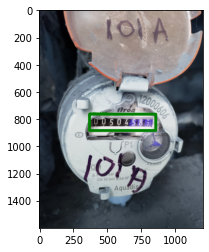

In [590]:
# Departamento
# image = cv2.imread('./data/depa/1.jpeg')
image = cv2.imread('./data/depa/new/2.jpeg') 
# image = cv2.imread('./data/depa/new/3.jpeg') 
# image = cv2.imread('./data/depa/new/4.jpeg') 
# image = cv2.imread('./data/unseen/2.jpeg')
# image = cv2.imread('./data/depa/6.jpeg')

(H, W) = image.shape[:2]

ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))
# loop over each of the layer outputs
boxes = []
confidences = []
classIDs = []
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.5:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,
	0.3)
image_tmp = image.copy()
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image_tmp, (x, y), (x + w, y + h), color, 20)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		print(text)
		cv2.putText(image_tmp, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
# show the output image
plt.imshow(image_tmp);

En caso de que sea detectado el objeto, se realiza un corte para aplicar filtros solo sobre el area que se encuentran los numeros. 

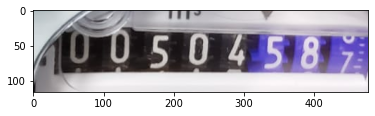

In [591]:
cla = 0
(x, y) = (boxes[cla][0], boxes[cla][1])
(w, h) = (boxes[cla][2], boxes[cla][3])

crop_img = image[y:y+h, x:x+w].copy()
plt.imshow(crop_img);

Se realiza un suavizado sobre la imagen recortada.

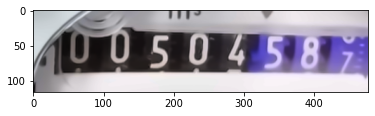

In [592]:
dst = cv2.fastNlMeansDenoisingColored(crop_img,None,10,10,7,21)
plt.imshow(dst);

Se convierte la imagen de BGR a GRAY

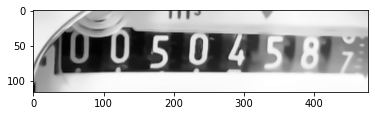

In [593]:
crop_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
plt.imshow(crop_gray, cmap='Greys_r');

Se aplica el filtro white top hat, fuente: https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_morphology.html

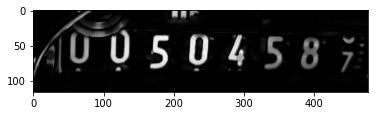

In [594]:
selem = disk(6)

w_tophat = white_tophat(crop_gray, selem)
plt.imshow(w_tophat, cmap='Greys_r');

Se aplica el filtro otsu.

<ipython-input-587-63f417fec1d8>:15: RuntimeWarning: invalid value encountered in true_divide
  muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)


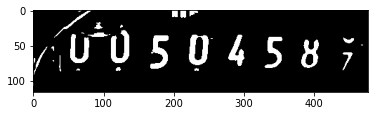

In [595]:
otsu_img = otsu(w_tophat)

plt.imshow(otsu_img, cmap='Greys_r');

Se obtienen los contornos, y se filtra el ruido dependiendo del area, altura, anchura y posicion. 

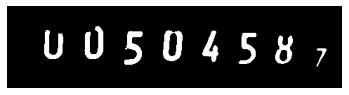

In [596]:
contours, hierarchy = cv2.findContours(otsu_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contours_dict = dict()
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    area = cv2.contourArea(cont)
    if area > 60 and h > 12 and w > 3 and y > 1:
        contours_dict[(x, y, w, h)] = cont


contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)

blank_background = np.zeros_like(otsu_img.copy())
img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=cv2.FILLED)
plt.axis('off')
plt.imshow(img_contours, cmap='Greys_r');

Las siguientes funciones ayudan a obtener los distintos contornos de los numeros para poder manipularlos por separado.

In [597]:
def is_overlapping_horizontally(box1, box2):
    x1, _, w1, _ = box1
    x2, _, _, _ = box2
    if x1 > x2:
        return is_overlapping_horizontally(box2, box1)
    return (x2 - x1) < w1

def merge(box1, box2):
    assert is_overlapping_horizontally(box1, box2)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x = min(x1, x2)
    w = max(x1 + w1, x2 + w2) - x
    y = min(y1, y2)
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def windows(contours):
    """return List[Tuple[x: Int, y: Int, w: Int, h: Int]]"""
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont)
        if not boxes:
            boxes.append(box)
        else:
            if is_overlapping_horizontally(boxes[-1], box):
                last_box = boxes.pop()
                merged_box = merge(box, last_box)
                boxes.append(merged_box)
            else:
                boxes.append(box)
    return boxes

Funcion para eliminar las imagenes que se encuentran en la carpeta de results.

In [598]:
import os, shutil

def delete_previous_results(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

Por cada contorno detectado, se guarda la imagen en la carpeta `results`.

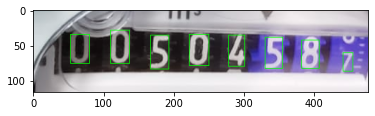

In [599]:
boxes = windows(contours_filtered)
delete_previous_results('./results')
for idx, box in enumerate(boxes):
    x, y, w, h = box
    img = cv2.rectangle(crop_img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi = otsu_img[y-10:y+h+10, x-10:x+w+10]
    cv2.imwrite('./results/'+ str(idx) +'.png', roi)

plt.imshow(crop_img);


Ejemplo de como se ve al seleccionar el segundo elemento de los contornos encontrados.

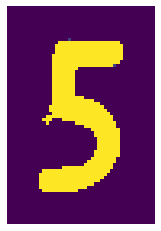

In [600]:
x, y, w, h = boxes[2]
plt.axis('off')
roi = otsu_img[y-10:y+h+10, x-10:x+w+10]
plt.imshow(roi);